In [132]:
using Luxor
using Colors
using Plots
using IterTools
using DataFrames
using OpenStreetMapX
using LightOSM
using KernelDensity
using Parsers
using Downloads
using OSMToolset
include("kernel_density.jl")
include("distance.jl")
include("prepare_data.jl")
include("analyse.jl")
include("plots.jl")
include("transform.jl")

matrix_log_scaling (generic function with 1 method)

In [3]:
function calc_tile_road_length(city_parse_data,city_centre)
    road_types = ["motorway", "trunk", "primary", "secondary", 
                "tertiary", "residential", "service", "living_street", 
                "motorway_link", "trunk_link", "primary_link", "secondary_link", 
                "tertiary_link"]
    
    total_length = 0.0
    
    for way in city_parse_data.ways
        if haskey(way.tags, "highway") && (way.tags["highway"] in road_types)
            for i in 1:(length(way.nodes) - 1)
                node1 = ENU(city_parse_data.nodes[way.nodes[i]],city_centre)
                node2 = ENU(city_parse_data.nodes[way.nodes[i + 1]],city_centre)
                total_length += OpenStreetMapX.distance(node1,node2)
            end
        end
    end
    return total_length
end

calc_tile_road_length (generic function with 1 method)

In [4]:
function calc_tile_area(bounds,tile_centre)
    node1 = ENU(bounds,tile_centre)
    return node1.min_x*2*node1.min_y*2
end

calc_tile_area (generic function with 1 method)

In [5]:
"""
y - lat/east
x - lon/north
"""
function rectangle(bounds, centre)
    ENU_coords = ENU(bounds,centre)
    return [ENU_coords.min_y, ENU_coords.min_y,
            ENU_coords.max_y, ENU_coords.max_y],
            [ENU_coords.min_x, ENU_coords.max_x,
            ENU_coords.max_x, ENU_coords.min_x]
end

rectangle

In [6]:
function get_city_bounds(city_name)
    boundaries_file = string(city_name,"_boundaries.osm")
    admin_city_centre = get_city_centre(boundaries_file)
    city_boundaries = extract_points_ENU(boundaries_file,admin_city_centre)
    return city_boundaries, admin_city_centre
end

get_city_bounds (generic function with 2 methods)

In [144]:
outfiles = tile_osm_file("Kielce.osm",nrow=50,ncol=50,out_dir="./tiles")

50×50 Matrix{String}:
 "50.7932894_50.795725264_20.5105231_20.514725196.osm"          …  "50.7932894_50.795725264_20.716425804_20.7206279.osm"
 "50.795725264_50.798161128_20.5105231_20.514725196.osm"           "50.795725264_50.798161128_20.716425804_20.7206279.osm"
 "50.798161128_50.800596991999996_20.5105231_20.514725196.osm"     "50.798161128_50.800596991999996_20.716425804_20.7206279.osm"
 "50.800596991999996_50.803032856_20.5105231_20.514725196.osm"     "50.800596991999996_50.803032856_20.716425804_20.7206279.osm"
 "50.803032856_50.80546872_20.5105231_20.514725196.osm"            "50.803032856_50.80546872_20.716425804_20.7206279.osm"
 "50.80546872_50.807904584_20.5105231_20.514725196.osm"         …  "50.80546872_50.807904584_20.716425804_20.7206279.osm"
 "50.807904584_50.810340448_20.5105231_20.514725196.osm"           "50.807904584_50.810340448_20.716425804_20.7206279.osm"
 "50.810340448_50.812776312_20.5105231_20.514725196.osm"           "50.810340448_50.812776312_20.716425804_20

In [145]:
dir = "tiles/"
files = readdir(dir)
bounds = []
lengths = []
areas = []
xs = []
ys = []

Any[]

In [146]:
test_file = joinpath(dir,files[7])
test_file
create_map(test_file;use_cache=false,trim_to_connected_graph=false)

MapData(OpenStreetMapX.Bounds{LLA}(50.7932894, 50.795725264, 20.535735676, 20.539937772000002), Dict{Int64, ENU}(417843795 => ENU(-139.5959893587369, 115.87042325725439, -0.0025777790419354574), 7720697640690408258 => ENU(136.4327815596899, -135.486241125841, -0.0028962509320962226), 417843792 => ENU(-74.25246205307366, 32.71392994335703, -0.0005152964517485259), 4397394207 => ENU(-106.87522960415292, 69.52525141029801, -0.0012728135888266934), 4397394191 => ENU(-52.35323293104971, 12.767553314140507, -0.00022721865627861604), 2243389634900341013 => ENU(-148.13552243665458, 130.05671592716888, -0.003043691163796325)), OpenStreetMapX.Way[OpenStreetMapX.Way(259365623, [7720697640690408258, 4397394191, 417843792, 4397394207, 417843795, 2243389634900341013], Dict("name" => "Droga Surowcowa", "highway" => "service", "access" => "private", "embankment" => "yes"))], Dict{Int64, Set{Int64}}(7720697640690408258 => Set([259365623]), 2243389634900341013 => Set([259365623])), Graphs.SimpleGraphs.S

In [147]:
boundaries, admin_city_centre = get_city_bounds("Kielce")
for elem in files
    file = joinpath(dir,elem)
    city_parse = OpenStreetMapX.parseOSM(file)
    mapp = create_map(file; use_cache = false, trim_to_connected_graph=false)
    city_centre = OpenStreetMapX.center(mapp.bounds)
    push!(bounds,mapp.bounds)
    push!(lengths, calc_tile_road_length(city_parse,city_centre))
    push!(areas, calc_tile_area(mapp.bounds,city_centre))
    x,y = rectangle(mapp.bounds,admin_city_centre)
    push!(xs,x)
    push!(ys,y)    
end

In [148]:
density = lengths./areas
denisty = min_max_scaling(density)

2500-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.11594979822164739
 0.14975086742748514
 0.11378027825747197
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.03841864096806968
 0.0
 0.0
 0.0848537029259619
 0.15007541369907734
 0.07448103992391694
 0.45797017710306065

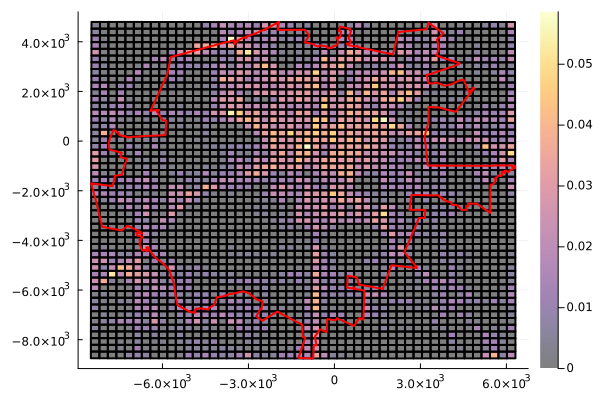

In [149]:
figure = Plots.plot()
grouped_ways = DataFrames.groupby(boundaries, :wayid)

for (y,x,d) in zip(xs,ys,density)
    Plots.plot!(figure, x, y, seriestype = :shape, lw = 2, fillalpha=0.5,
                linecolor = :black, legend = false, fill_z=d)
end

for (key, way) in pairs(grouped_ways)
    Plots.plot!(figure, way.x, way.y, label="wayid $(key)", 
                                    line=:path,legend=false,linecolor=:red,
                                    linewidth=2)
end

figure